# Bootstrapping
In this Jupyter Notebook...
- Review multivariate linear regression by using it to predict band gap energy from molecular properties
- Use bootstrapping to determine our confidence in $R^2$ values
- Examine limitations to bootstrapping

Import modules

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import json
import pandas as pd
from sklearn import linear_model
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.utils import resample
import scipy.stats as st

Load data

Data is pulled from the Open Quantum Materials Database: http://oqmd.org

Citations:
   - http://dx.doi.org/10.1007/s11837-013-0755-4
   - http://dx.doi.org/10.1038/npjcompumats.2015.10

We are using all molecules from OQMD containing both tungsten and nitrogen - about 250 molecules

In [2]:
# load data - data is in a json file format
data_list = []
for i in range(1,6):
    filename = 'data/W/formationenergy'+str(i)+'.json'
    with open(filename) as json_file:
        jfile = json.load(json_file)
        data_list = data_list + (jfile['data'])
df = pd.DataFrame(data_list)

# choose independent variables
indep_vars = ['volume','natoms','stability','delta_e']

# choose dependent variable
dep_var = 'band_gap'

# remove examples with missing values
xs = df[indep_vars].to_numpy()
xs = np.delete(xs,0,0)
ys = df[dep_var].to_numpy()
ys = np.delete(ys,0,0).reshape(-1,1)
all_data = np.concatenate((xs,ys),axis=1)
all_data  = all_data[~np.isnan(all_data).any(axis=1),:]
xs = all_data[:,:len(indep_vars)]
ys = all_data[:,-1]

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}

Not all molecules have a band gap energy. We are removing all the molecules from our dataset with a value of zero for the band gap energy. Then we are normalizing and standardizing the data.

In [3]:
# remove values of zero
newxs = xs[ys!=0]
newys = ys[ys!=0]

# normalize and standardize data
xmean = newxs.mean(axis=0)
xvar = np.sqrt(newxs.var(axis=0))
newxs = newxs-xmean
newys = newys-newys.mean(axis=0)
newxs = newxs/xvar
newys = newys/(np.sqrt(newys.var(axis=0)))

Visualize Data

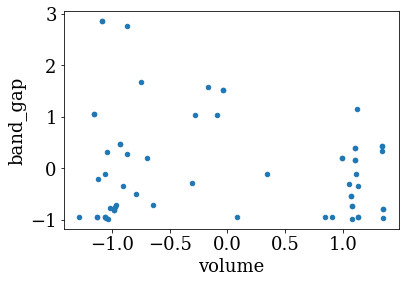

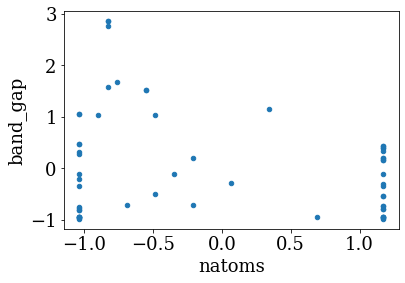

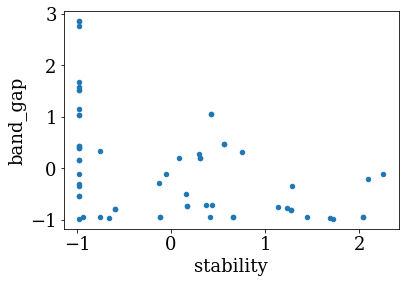

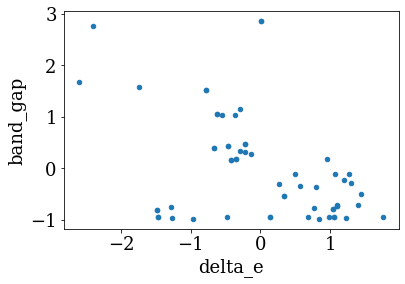

In [4]:
# plot data one at a time
plt.rc('font', **font)
for i in range(len(indep_vars)):
   plt.scatter(newxs[:,i],newys,20)
   plt.xlabel(indep_vars[i])
   plt.ylabel(dep_var)
   plt.show()

### Creating a linear regression model
Create a multivariate linear regression model to predict the band gap energy

Plot the model for each covariate

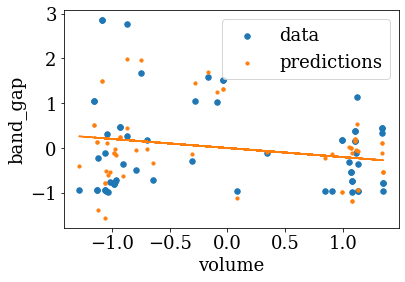

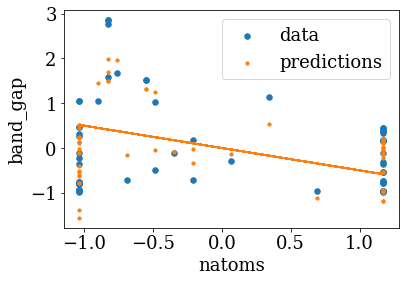

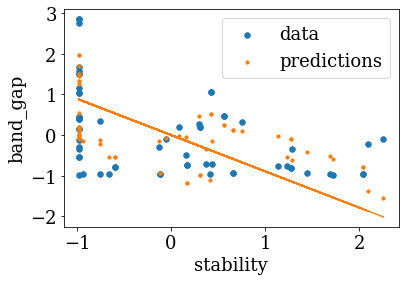

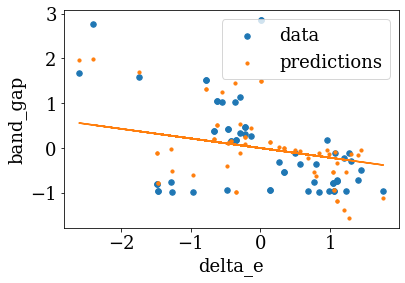

In [5]:
# create model and calculate prediction performance
regr = linear_model.LinearRegression()
model = regr.fit(newxs,newys)
y_preds = model.predict(newxs)

# plot data and lines of best fit
plt.rc('font', **font)
for i in range(len(indep_vars)):
    plt.scatter(newxs[:,i],newys,30,label='data')
    model_plot = regr.intercept_ + regr.coef_[i]*newxs[:,i]
    plt.plot(newxs[:,i],model_plot,color='C1')
    plt.scatter(newxs[:,i],y_preds,10,label='predictions')
    plt.xlabel(indep_vars[i])
    plt.ylabel(dep_var)
    plt.legend()
    plt.show()

Calculate the $R^2$ value of the fit. Plot the true band gap energy values versus the predicted values

R2:  0.65072860553565


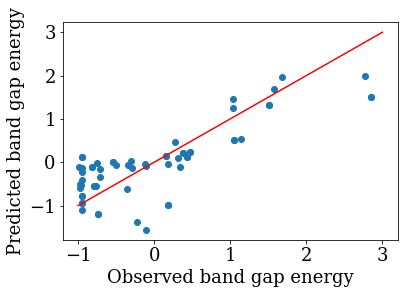

In [6]:
# calculate R^2 value
r2 = r2_score(newys,y_preds)
print('R2: ',r2)

# plot data and line of best fit
plt.rc('font', **font)
plt.scatter(newys,y_preds)
plt.plot([-1,3],[-1,3],'r')
plt.xlabel('Observed band gap energy')
plt.ylabel('Predicted band gap energy')
plt.show()

### Using bootstrapping to examine R2 Values

Bootstrapping is typically used to determine our confidence in statistical variables (like the mean or fit parameters), but here we will use it to examine our confidence in $R^2$.

In [7]:
def r2_bootstrap(xs, ys, n_samples, n_boot):
    '''
    Create a distribution of different R^2 values of a linear regression problem,
        predicting ys from xs
    inputs:
        xs: independent variables of data, 2D array
        ys: dependent variable of data, 1D array
        n_samples: number of samples to use for a bootstrapping trial, integer
        n_boot: number of bootstrapping trials to run, integer
    outputs:
        r2s: list of R2 values from each bootstrapping trial
    '''
    r2s = []
    # run n_boot number of trials
    for i in range(n_boot):
        # create an array of indices of our dependent-variable array
        inds = range(len(ys))
        # create an array of randomly-sampled indices with n_samples number of samples
        boot = resample(inds, replace=True, n_samples=n_samples)
        # use the indices to choose random samples from the independent and dependent variable arrays
        samplex = xs[boot,:]
        sampley = ys[boot]
        # create regression model from the sampled data
        regr = linear_model.LinearRegression()
        model = regr.fit(samplex,sampley)
        # predict the dependent variable using the model
        y_preds = model.predict(samplex)
        # calculate the R^2 value of the fit
        r2 = r2_score(sampley,y_preds)
        # add this value to an array of R^2 values from every trial
        r2s.append(r2)
    return r2s

First, we perform bootstrapping with a number of samples equal to the number of datapoints and 500 trials

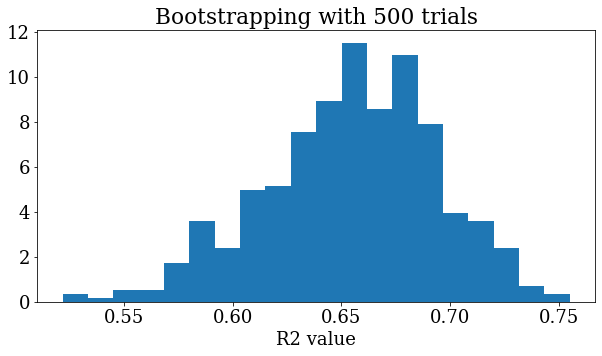

In [8]:
# set bootstrapping parameters
n_samples = len(ys)
n_boot = 500

# run bootstrapping
r2s = r2_bootstrap(newxs,newys,n_samples,n_boot)

# plot histogram of R^2 values across 500 trials
figure,ax = plt.subplots(figsize=(10,5))
ax.hist(r2s,20,density=True);
ax.set_xlabel('R2 value')
ax.set_title('Bootstrapping with 500 trials')
plt.show()

How are our bootstrapping results affected by the number of samples we use?

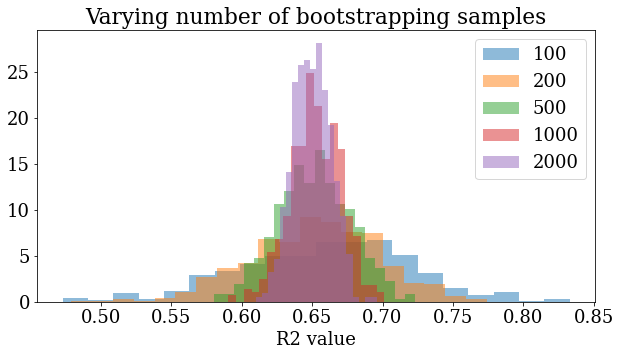

In [9]:
# Changing number of observations
sample_list = [100,200,500,1000,2000]
n_boot = 500

# run bootstrapping and plot
figure,ax = plt.subplots(figsize=(10,5))
for n_samples in sample_list:
    r2s = r2_bootstrap(newxs,newys,n_samples,n_boot)
    ax.hist(r2s,20,alpha=0.5,label=str(n_samples),density=True);
ax.legend()
ax.set_xlabel('R2 value')
ax.set_title('Varying number of bootstrapping samples')
plt.show()

The variance of the bootstrapping distribution is highly sensitive to the number bootstrapping samples. Because of this, using a number of samples higher than the number of data points is not typical.

How are our bootstrapping results affected by the number of trials/number of times we perform sampling?

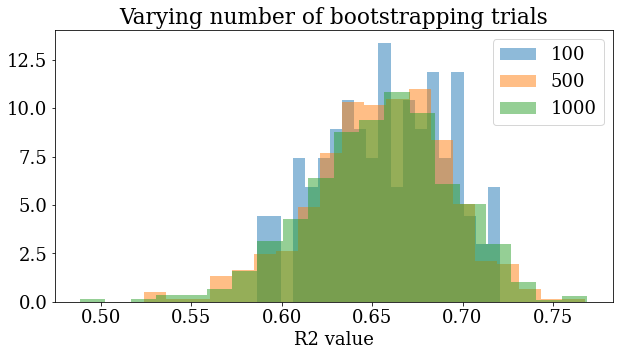

In [10]:
# Changing number of trials
n_samples = len(ys)
boot_list = [100,500,1000]

# run bootstrapping and plot
figure,ax = plt.subplots(figsize=(10,5))
plt.rc('font', **font)
for n_boot in boot_list:
    r2s = r2_bootstrap(newxs,newys,n_samples,n_boot)
    ax.hist(r2s,20,alpha=0.5,label=str(n_boot),density=True);
ax.legend()
ax.set_title('Varying number of bootstrapping trials')
ax.set_xlabel('R2 value')
plt.show()

Increasing the number of trials increases the normality of our distribution, according to the central limit theorem. Because of this, always use a large number of trials when applying bootstrapping.

Bootstrapping should not typically be used for examining $R^2$ values because bootstrapping assumes the existence of a $\textit{fixed}$ $\textit{hyperparameter}$, which bootstrapping is used to find the $\textit{true}$ value of. We'll talk more about this in week 8 when we explore Bayesian inference. In the homework, you'll be using bootstrapping to examine confidence in model fit parameters.